In [1]:
import sys
import os

import matplotlib.pyplot as plt

from Mala.mala import MALAKernel

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [116]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *
from Utils.tools import *

In [58]:
def run(dim_parameters, dim_observations, p, beta, num_particles, noise_level=1e-6):
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    forward_model = LinearForwardModel(
        dim_parameters, dim_observations, p, coef=jnp.pi ** (-2)
    )
    i_array = jnp.linspace(1, dim_parameters, dim_parameters)
    v0 = jnp.apply_along_axis(lambda x: x ** (-beta), 0, i_array)

    y_true = forward_model.evaluate(v0[:, jnp.newaxis])[:, 0] #(dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    prior_cov = GaussianKernel(dim_parameters, 2)._operator_fourier
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=jnp.zeros(dim_parameters),
        noise_level=noise_level,
        time_interval=(0.0, 150.0, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=1,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results, v0

In [4]:
# Problem parameters
dim_parameters = 100
dim_observations = 100
p = 2
beta = 5 / 2
num_particles = 100

noise_levels = [1e-2,1e-4,1e-6,1e-8]
print(noise_levels)

[0.01, 0.0001, 1e-06, 1e-08]


In [5]:
results_list = []
for noise_level in noise_levels:
    results, v0 = run(dim_parameters, dim_observations, p, beta, num_particles, noise_level)
    results_list.append(results)

0
converged

Algorithm converged: True
Stopping time: 0
Final residual: 0.124189
0
converged

Algorithm converged: True
Stopping time: 0
Final residual: 0.083945
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.000451
0
1
2
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.000037


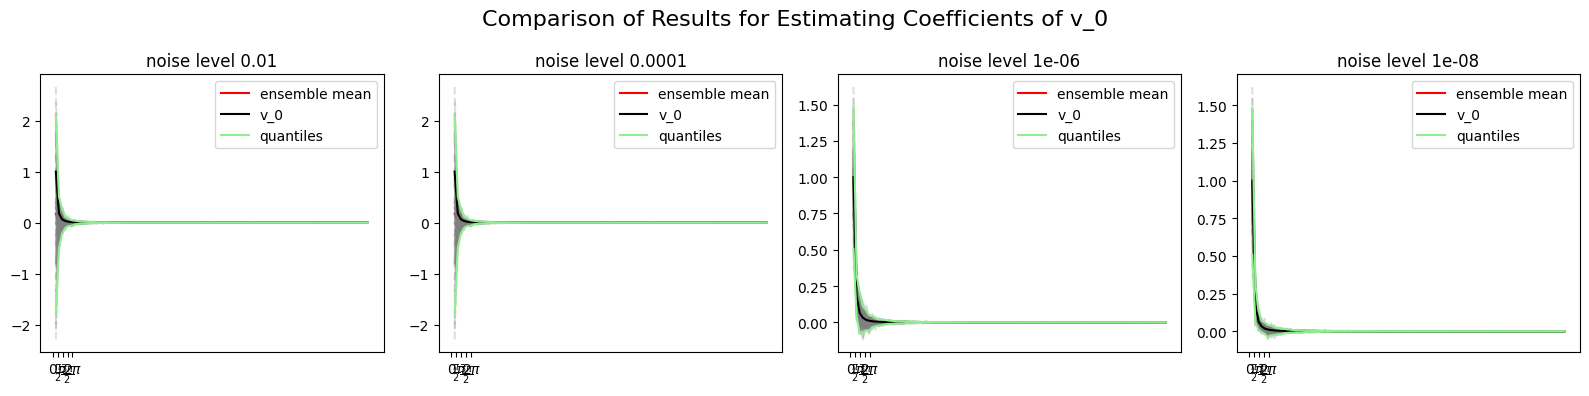

In [7]:
i_array = jnp.linspace(1, 100, 100)
q = jnp.array([0.025, 0.975])

# Create a figure with subplots based on the number of results
num_results = len(results_list)
fig, axes = plt.subplots(1,num_results, figsize=(4*num_results,4), sharex=True)

# If there's only one result, axes won't be iterable, so we handle that case
if num_results == 1:
    axes = [axes]

# Loop through the results and create a plot for each one
for i, results in enumerate(results_list):
    hat_coefs_v0_ensemble = results["ensemble_history"][-1]

    # Plot on the current subplot
    ax = axes[i]

    # Plot ensemble mean
    ax.plot(
        i_array, jnp.mean(hat_coefs_v0_ensemble, axis=1),
        color="red", label="ensemble mean"
    )

    # Plot individual ensemble members
    ax.plot(
        i_array, hat_coefs_v0_ensemble,
        color="grey", linestyle="dashed", alpha=0.25
    )

    # Plot true v0
    ax.plot(i_array, v0, color="black", label="v_0")

    # Plot quantiles
    ax.plot(
        i_array,
        jnp.quantile(hat_coefs_v0_ensemble, q, axis=1)[0],
        color="lightgreen",
        label="quantiles",
    )
    ax.plot(
        i_array,
        jnp.quantile(hat_coefs_v0_ensemble, q, axis=1)[1],
        color="lightgreen"
    )

    # Add title and legend to each subplot
    ax.set_xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi])
    ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
    ax.set_title(f"noise level {noise_levels[i]}")
    ax.legend()

# Add a common title for the entire figure
fig.suptitle("Comparison of Results for Estimating Coefficients of v_0", fontsize=16)
plt.tight_layout()
plt.show()

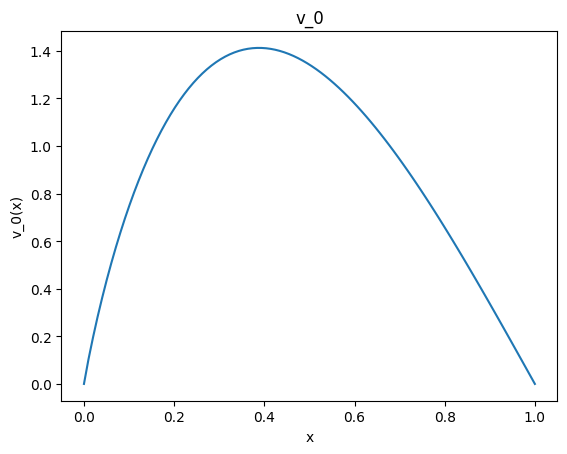

In [8]:
N = 100  # num of grid points
x = jnp.linspace(0, 1, N)
v0_func = get_function(v0, x)
plt.plot(x, v0_func)
plt.xlabel("x")
plt.ylabel("v_0(x)")
plt.title("v_0")
plt.show()

In [118]:
def compute_laplace(D, h):
    # Create empty matrix with JAX
    Lap = jnp.zeros((D + 1, D + 1))

    # Get diagonal indices
    diag_indices = kth_diag_indices(Lap, 0)
    diag_lower_indices = kth_diag_indices(Lap, -1)
    diag_upper_indices = kth_diag_indices(Lap, 1)

    # Create updated arrays with values set at specific indices
    Lap = Lap.at[diag_indices].set(-2)
    Lap = Lap.at[diag_lower_indices].set(1)
    Lap = Lap.at[diag_upper_indices].set(1)

    # Set corner values for periodic boundary
    # Lap = Lap.at[0, -1].set(1)
    # Lap = Lap.at[-1, 0].set(1)

    # Scale by 2h²
    Lap = Lap / (2 * (h**2))

    return Lap

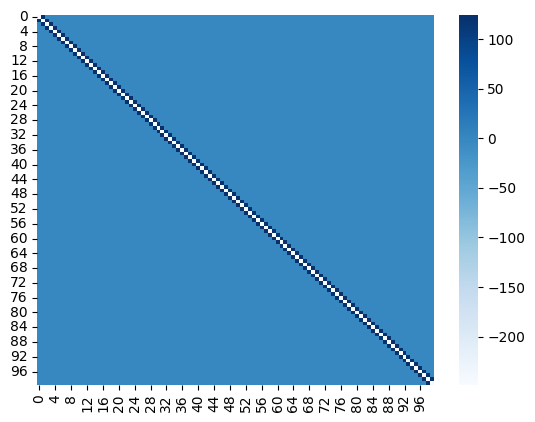

In [119]:
D = N - 1
L = 2 * jnp.pi
h = L / D
x_indices = jnp.arange(D + 1)
x_array = (2 * jnp.pi * x_indices) / (D + 1)
f_array = jnp.exp(0.5 * jnp.sin(x_array))
plot = True
fourier = False
laplace = compute_laplace(D, h)
sns.heatmap(laplace, cmap="Blues")
plt.show()

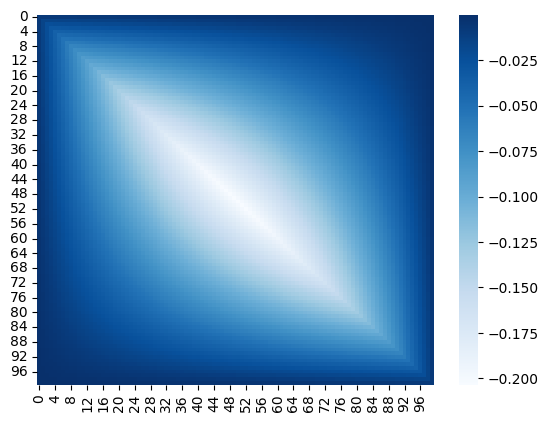

In [120]:
K = jnp.linalg.pinv(laplace)
sns.heatmap(K, cmap="Blues")
plt.show()

In [11]:
v0_func_ensemble = get_function(hat_coefs_v0_ensemble, x)
v0_func_ensemble.shape

(100, 100)

In [12]:
# Create g_array (right-hand side)
g_tilde = jnp.ones(N) + x_array
f0 = solution_map(v0_func, K, g_tilde)

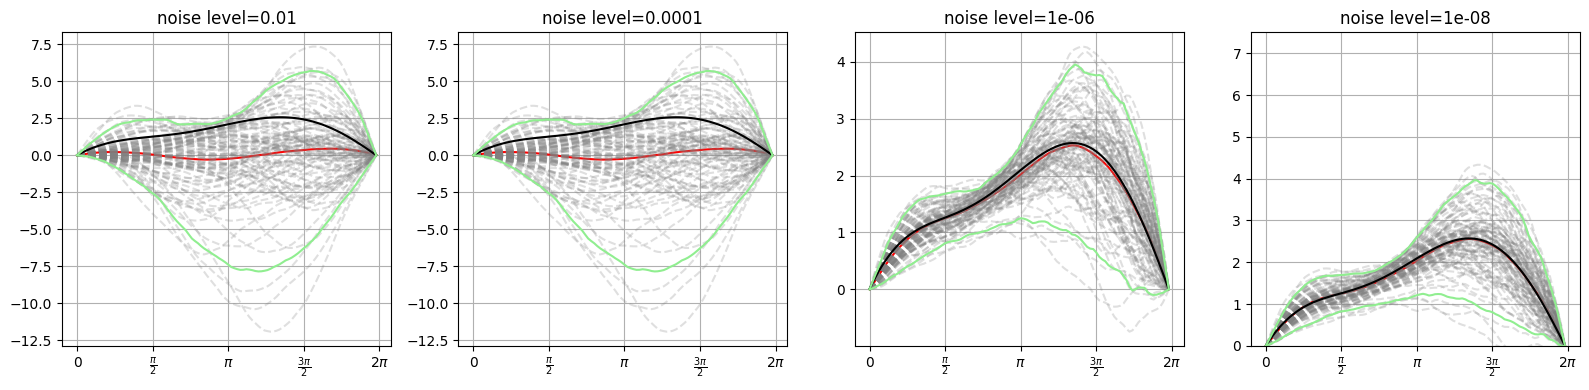

In [13]:
i_array = jnp.linspace(1, 100, 100)
q = jnp.array([0.025, 0.975])

# Create a figure with subplots based on the number of results
num_results = len(results_list)
fig, axes = plt.subplots(1,num_results, figsize=(4*num_results,4), sharex=True)

# If there's only one result, axes won't be iterable, so we handle that case
if num_results == 1:
    axes = [axes]

# Loop through the results and create a plot for each one
for i, results in enumerate(results_list):
    hat_coefs_v0_ensemble = results["ensemble_history"][-1]
    v0_func_ensemble = get_function(hat_coefs_v0_ensemble, x)
    f0_ensemble = solution_map(v0_func_ensemble, K, g_tilde)
    # Plot on the current subplot
    ax = axes[i]

    # Plot ensemble mean
    ax.plot(
        x_array, jnp.mean(f0_ensemble, axis=1),
        color="red", label="ensemble mean"
    )

    # Plot individual ensemble members
    ax.plot(
        x_array, f0_ensemble,
        color="grey", linestyle="dashed", alpha=0.25
    )

    # Plot true v0
    ax.plot(x_array, f0, color="black", label="v_0")

    # Plot quantiles
    ax.plot(
        x_array,
        jnp.quantile(f0_ensemble, q, axis=1)[0],
        color="lightgreen",
        label="quantiles",
    )
    ax.plot(
        x_array,
        jnp.quantile(f0_ensemble, q, axis=1)[1],
        color="lightgreen"
    )

    # Add title and legend to each subplot
    ax.set_xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi])
    ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
    ax.set_title(f"noise level={noise_levels[i]}")
    ax.grid(True)

# Add a common title for the entire figure
#fig.suptitle("Comparison of Results for Estimating Coefficients of v_0", fontsize=16)
plt.ylim(0,7.5)
plt.tight_layout()
plt.show()

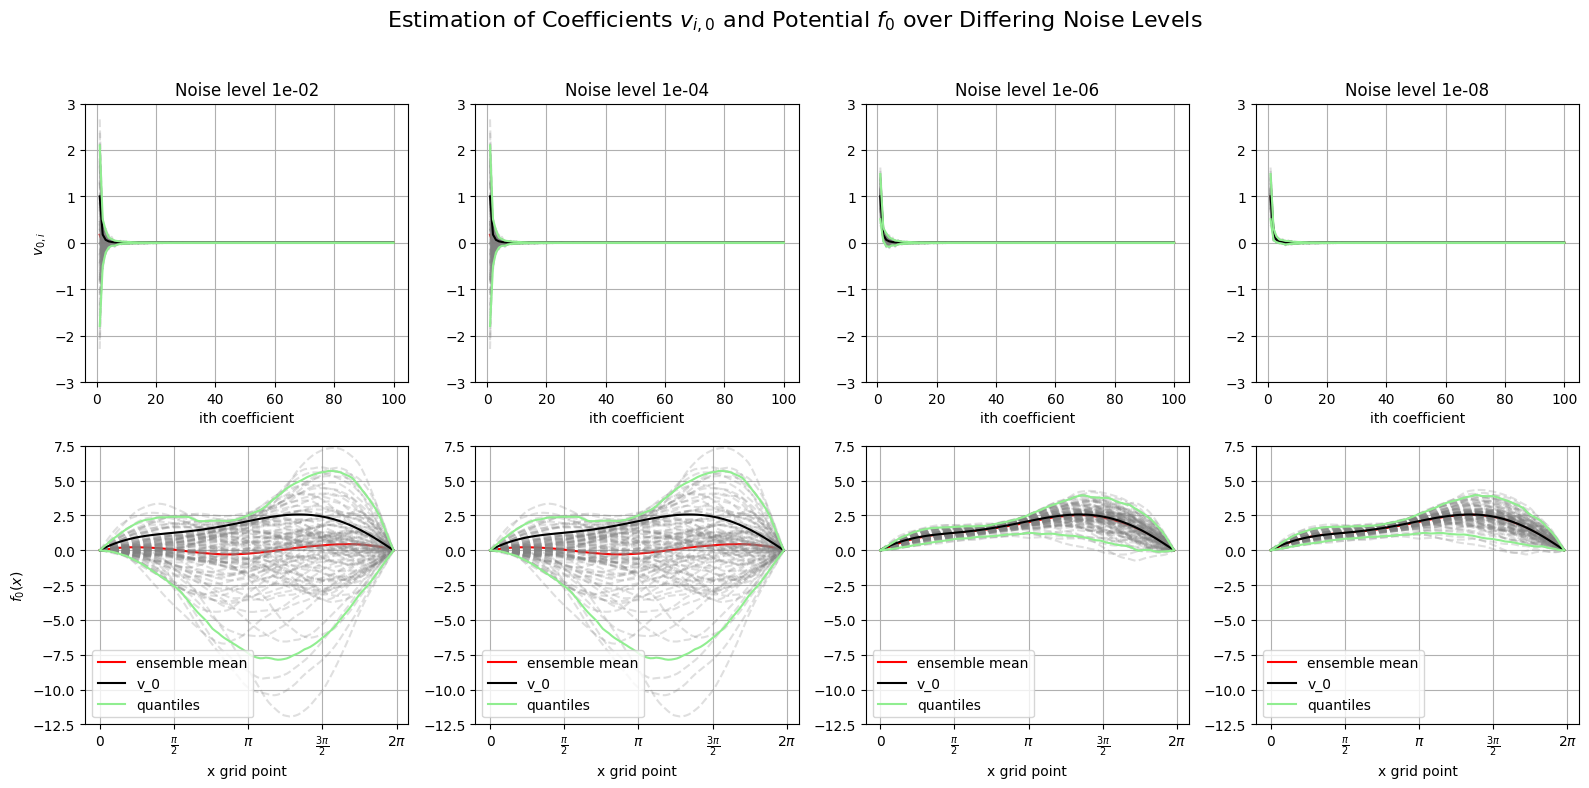

In [14]:
import matplotlib.pyplot as plt

q = jnp.array([0.025, 0.975])
num_results = len(results_list)
fig, axes = plt.subplots(2, num_results, figsize=(4*num_results, 8))


if num_results == 1:
    axes = axes.reshape(2, 1)

for i, results in enumerate(results_list):
    hat_coefs_v0_ensemble = results["ensemble_history"][-1]
    v0_func_ensemble = get_function(hat_coefs_v0_ensemble, x)
    f0_ensemble = solution_map(v0_func_ensemble, K, g_tilde)

    # --- Top Plot: hat_coefs_v0_ensemble ---
    ax_top = axes[0, i]
    ax_top.plot(i_array, jnp.mean(hat_coefs_v0_ensemble, axis=1), color="red", label="ensemble mean")
    ax_top.plot(i_array, hat_coefs_v0_ensemble, color="grey", linestyle="dashed", alpha=0.25)
    ax_top.plot(i_array, v0, color="black", label="v_0")
    ax_top.plot(i_array, jnp.quantile(hat_coefs_v0_ensemble, q, axis=1)[0], color="lightgreen", label="quantiles")
    ax_top.plot(i_array, jnp.quantile(hat_coefs_v0_ensemble, q, axis=1)[1], color="lightgreen")
    ax_top.set_xlabel("ith coefficient")
    ax_top.set_ylim(-3,3)
    ax_top.grid(True)
    if i == 0:
        ax_top.set_ylabel(r"$v_{0,i}$")


    # --- Bottom Plot: f0_ensemble ---
    ax_bottom = axes[1, i]
    ax_bottom.plot(x_array, jnp.mean(f0_ensemble, axis=1), color="red", label="ensemble mean")
    ax_bottom.plot(x_array, f0_ensemble, color="grey", linestyle="dashed", alpha=0.25)
    ax_bottom.plot(x_array, f0, color="black", label="v_0")
    ax_bottom.plot(x_array, jnp.quantile(f0_ensemble, q, axis=1)[0], color="lightgreen", label="quantiles")
    ax_bottom.plot(x_array, jnp.quantile(f0_ensemble, q, axis=1)[1], color="lightgreen")
    ax_bottom.set_xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi])
    ax_bottom.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
    ax_bottom.set_xlabel("x grid point")
    ax_bottom.set_ylim(-12.5, 7.5)
    ax_bottom.grid(True)
    if i == 0:
        ax_bottom.set_ylabel(r"$f_0(x)$")
    ax_bottom.legend()

    # Set column title once at the top
    axes[0, i].set_title(f"Noise level {noise_levels[i]:.0e}")

# Common figure title
fig.suptitle("Estimation of Coefficients ${v}_{i,0}$ and Potential $f_0$ over Differing Noise Levels", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [15]:
# def gaussian_log_prior(theta, sigma_prior):
#
#     sign, logdet = jnp.linalg.slogdet(sigma_prior)
#
#     # Compute  θᵀΣ⁻¹θ
#     quad_form = theta.T @ jnp.linalg.solve(sigma_prior, theta)
#
#
#     return -0.5 * (logdet + quad_form)
#
#
# def create_log_posterior(
#     regression_model, y, sigma_prior, sigma_noise=1.0, log_prior_fn=None
# ):
#     # Use provided prior or default to Gaussian
#     if log_prior_fn is None:
#         #print(sigma_prior)
#         log_prior_fn = partial(gaussian_log_prior, sigma_prior=sigma_prior)
#
#     def log_posterior_fn(theta):
#         log_like = regression_model.log_likelihood(theta, y)
#         log_prior = log_prior_fn(theta)
#         return log_like + log_prior
#
#     return log_posterior_fn

In [16]:
# key = random.PRNGKey(42)
# noise_level = 1e-6
# model = Schroedinger(D,D,f0, g_tilde, plot=False)
# uf0 = model.evaluate_single(f0)

In [17]:
# plt.plot(uf0)
# plt.show()

In [18]:
# Add noise to observations
# key, subkey = random.split(key)
# noise = noise_level * random.normal(subkey, uf0.shape)
# observations = uf0 + noise

In [19]:
# log_posterior = create_log_posterior(model, observations, K**(2))

In [20]:
# model.log_likelihood(uf0,observations)

In [21]:
# log_posterior(uf0)

In [22]:
# from Mala.mala import *
# from Mala.sample import *
#
# mala_kernel = MALAKernel(log_posterior, epsilon=1e-3)
#
# mcmc = MCMC(mala_kernel, D=D+1, n_steps = 10000, n_chains = 10, initializer="deter", uf0=uf0)

In [23]:
# samples = mcmc.sample()

In [24]:
# samples.shape #num of chains x steps x dim

In [25]:
# for chain_idx in range(samples.shape[0]):
#     print(chain_idx)
#     sample= samples[chain_idx, ][-1]
#     print(sample.shape)


In [26]:
# samples[:,-1,:].shape

In [27]:
#plt.plot(samples[1,:,0])

In [28]:
# plt.plot(jnp.mean(samples[:,-1,:], axis=0), color="red")
# plt.plot(uf0, color="black")
# plt.plot(samples[:,-1,:].T, color="grey", linestyle="dashed", alpha=0.25)
# plt.show()

In [29]:
# def e(uf, L):
#     return L@uf / (2*uf)
# uhat = jnp.mean(samples[:,-1,:], axis=0)
#
# fhat =  e(uhat, laplace)

In [30]:
def get_coefs(f_vals: jnp.ndarray, x: jnp.ndarray, N: int) -> jnp.ndarray:
    """
    Project a function (given by its values at points x) onto the first N Laplace eigenfunctions.

    Parameters:
    ----------
    f_vals : jnp.ndarray
        Function values at points x (shape: [M,])
    x : jnp.ndarray
        Grid points in [0, 1] (shape: [M,])
    N : int
        Number of basis functions to project onto

    Returns:
    -------
    w : jnp.ndarray
        Coefficients in Laplace eigenfunction basis (shape: [N,])
    """
    dx = x[1] - x[0]  # assume uniform grid
    k_vals = jnp.arange(1, N + 1)
    Phi = jnp.sqrt(2) * jnp.sin(jnp.outer(k_vals, jnp.pi * x))  # shape (N, M)
    w = jnp.dot(Phi, f_vals) * dx  # shape (N,)
    return w

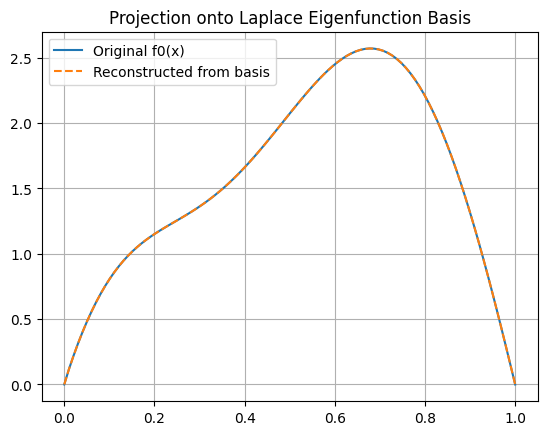

In [67]:


# Project to Laplace basis
N = 100
f_hat = get_coefs(f0, x, N)

# Reconstruct from coefficients
f0_reconstructed = get_function(f_hat, x)

# Plot
import matplotlib.pyplot as plt
plt.plot(x, f0, label="Original f0(x)")
plt.plot(x, f0_reconstructed, '--', label="Reconstructed from basis")
plt.legend()
plt.grid(True)
plt.title("Projection onto Laplace Eigenfunction Basis")
plt.show()

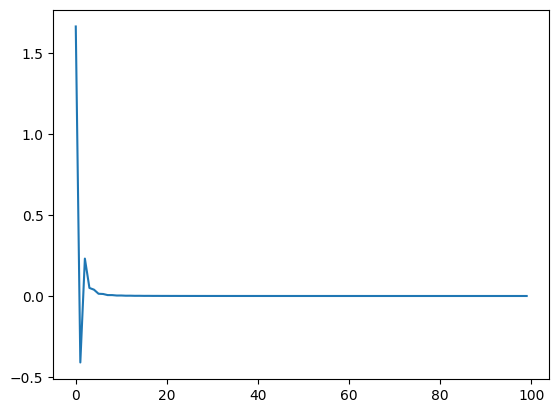

In [68]:
plt.plot(f_hat)
plt.show()

In [54]:
dim_parameters = 100
num_particles = 50
init_mean=jnp.zeros(dim_parameters)
prior_covf0 = GaussianKernel(dim_parameters, 2)._operator_fourier
key = random.PRNGKey(42)


In [55]:
def sample_prior(key, dim_parameters, num_particles, init_mean, init_covariance) -> jnp.ndarray:
    """
    Sample the initial ensemble from the prior distribution.

    Returns:
        Initial ensemble of shape (dim_parameters, num_particles).
    """
    # Generate standard normal samples
    samples = random.normal(
        key, shape=(dim_parameters, num_particles)
    )

    # Transform to the specified prior distribution
    return init_mean[:, jnp.newaxis] + jnp.dot(init_covariance, samples)

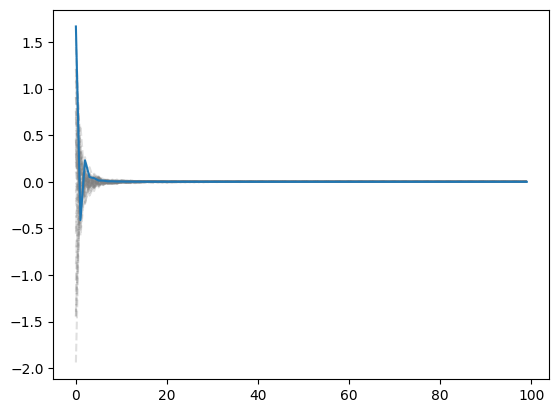

In [112]:
prior_samples = sample_prior(key, dim_parameters, num_particles, init_mean, prior_covf0)
plt.plot(prior_samples, color = "grey", linestyle="dashed", alpha=0.25)
plt.plot(f_hat)
plt.show()

In [94]:
model = LinearForwardModel(
        dim_parameters, dim_observations, 2, coef=jnp.pi ** (-2)
    )
lap_fourier = model.operator

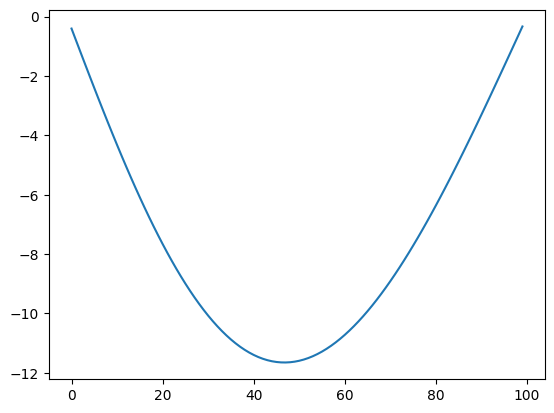

In [133]:
uf0_func = K@v0_func
plt.plot(uf0_func)
plt.show()

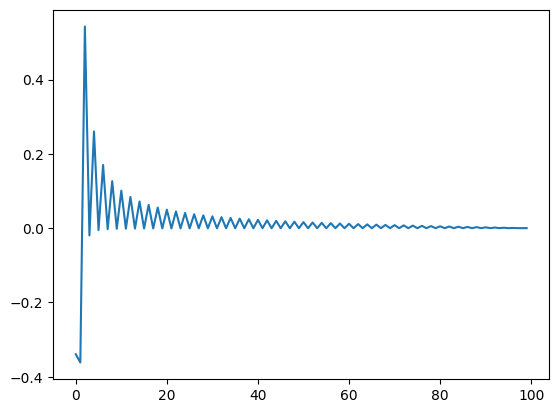

In [110]:
uf0_hat = get_coefs(uf0_func, x, N)
plt.plot(uf0_hat)
plt.show()

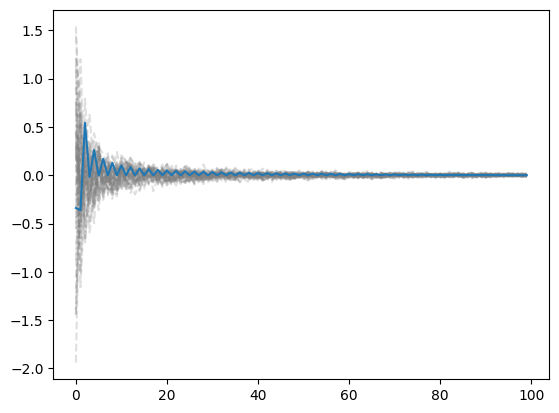

In [113]:
dim_parameters = 100
num_particles = 50
init_mean=jnp.zeros(dim_parameters)
prior_covf0 = GaussianKernel(dim_parameters, 1)._operator_fourier
key = random.PRNGKey(42)



prior_samples = sample_prior(key, dim_parameters, num_particles, init_mean, prior_covf0)
plt.plot(prior_samples, color = "grey", linestyle="dashed", alpha=0.25)
plt.plot(uf0_hat)
plt.show()

In [131]:

def forward_solve_dirichlet(f_potential, laplace, g_left=0.0, g_right=0.0):
    """
    Solves (1/2)*Δu - f*u = 0 with u[0]=g_left, u[-1]=g_right (Dirichlet BCs)
    """
    D_minus_1 = f_potential.shape[0]  # interior only

    A = laplace - jnp.diag(f_potential)

    # Right-hand side includes boundary terms
    rhs = jnp.zeros(D_minus_1)
    rhs = rhs.at[0].set(rhs[0] - 0.5 * g_left / h**2)
    rhs = rhs.at[-1].set(rhs[-1] - 0.5 * g_right / h**2)

    u_inner = jnp.linalg.solve(A, rhs)



    return u_inner

u_f = forward_solve_dirichlet(f0, laplace, g_left=1, g_right=7.2)

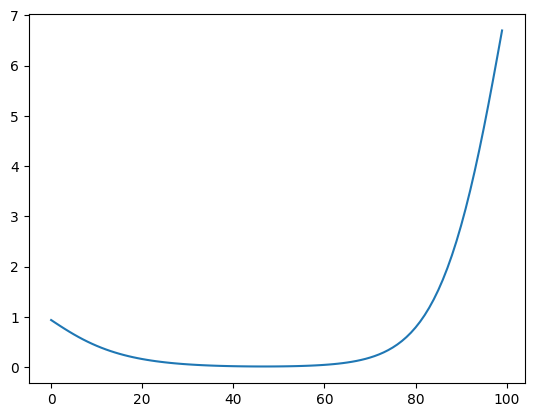

In [132]:
plt.plot(u_f)
plt.show()